# linear regression

### 00 | setting up

In [49]:
import pandas as pd
import numpy as np 
import os
import janitor
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy

In [64]:
path = r'/Users/johntam/cf_data_analysis/tasks/A6/data'

eu_data = pd.read_csv(os.path.join(path,'eu_data.csv'))

In [3]:
eu_data.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,weekends,city
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,0,amsterdam
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,0,amsterdam
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,0,amsterdam
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,0,amsterdam
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,0,amsterdam


### 01 data preprocessing 

In [65]:
# switching out boolean values for the regression

eu_data.replace({False: 0, True: 1},inplace=True)

In [47]:
eu_data.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,weekends,city
0,194.033698,Private room,0,1,2.0,0,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,0,amsterdam
1,344.245776,Private room,0,1,4.0,0,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,0,amsterdam
2,264.101422,Private room,0,1,2.0,0,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,0,amsterdam
3,433.529398,Private room,0,1,4.0,0,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,0,amsterdam
4,485.552926,Private room,0,1,2.0,1,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,0,amsterdam


In [6]:
eu_data.columns

Index(['realSum', 'room_type', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat', 'weekends', 'city'],
      dtype='object')

In [66]:
# removing outliers from realSum column

q1 = eu_data.realSum.quantile(0.25)
q3 = eu_data.realSum.quantile(0.75)
iqr = q3-q1

reg_data = eu_data = eu_data[(eu_data['realSum'] >= q1 - 1.5 * iqr) & (eu_data['realSum'] <= q3 + 1.5 * iqr)]


In [67]:
def remove_outliers(df, col_name):
    
    grouped = df.groupby('city')
   
    cleaned_data = []
    
    for country, group in grouped:
        
        z_scores = scipy.stats.zscore(group[col_name])
        
        outlier_indexes = np.where(np.abs(z_scores) > 3)
      
        cleaned_city = group.drop(group.index[outlier_indexes])
     
        cleaned_data.append(cleaned_city)
   
    cleaned_df = pd.concat(cleaned_data)
    return cleaned_df

reg_data = remove_outliers(reg_data,'realSum')

In [ ]:
reg_data.room_type.value_counts()

In [68]:
# creating dummy variables for city and room variables

reg_data = reg_data.drop(['room_private','room_shared','attr_index_norm','rest_index_norm'], axis=1) # these variables are unneeded as the former will be recreated and the latter is not necessary for we will scale our factors later

reg_data = (pd.concat([reg_data, pd.get_dummies(reg_data[['city','room_type']], drop_first=True)], axis=1)
    .clean_names()
    .drop(['room_type','city'],axis = 1)
    .reset_index(drop = True)
)

In [10]:
reg_data.head()

,realsum,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,...,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,room_type_private_room,room_type_shared_room
0,194.033698,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,...,0,0,0,0,0,0,0,0,1,0
1,344.245776,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,...,0,0,0,0,0,0,0,0,1,0
2,264.101422,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,...,0,0,0,0,0,0,0,0,1,0
3,433.529398,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,...,0,0,0,0,0,0,0,0,1,0
4,485.552926,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,...,0,0,0,0,0,0,0,0,1,0


In [70]:
# scaling features

features_to_scale = ['person_capacity','cleanliness_rating','guest_satisfaction_overall','bedrooms','dist','metro_dist','attr_index','rest_index']

for feature in features_to_scale:
    reg_data[feature] = MinMaxScaler(feature_range=(0, 1)).fit_transform(reg_data[[feature]])

### 02 | linear regression

In [55]:
reg_data.columns

Index(['realsum', 'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'rest_index', 'lng', 'lat', 'weekends',
       'city_athens', 'city_barcelona', 'city_berlin', 'city_budapest',
       'city_lisbon', 'city_london', 'city_paris', 'city_rome', 'city_vienna',
       'room_type_private_room', 'room_type_shared_room'],
      dtype='object')

In [71]:
# defining independent and dependent variables

y = reg_data['realsum']

X = reg_data.drop(['lat','lng','realsum'], axis = 1)


In [72]:
# using VIF to avoid multicolinearity

# calculate VIF for each independent variable
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                     variables         VIF
0              person_capacity    3.407079
1            host_is_superhost    1.521017
2                        multi    1.932392
3                          biz    2.274659
4           cleanliness_rating  121.912312
5   guest_satisfaction_overall  128.378525
6                     bedrooms    6.779252
7                         dist    8.252656
8                   metro_dist    2.760116
9                   attr_index    9.769361
10                  rest_index   12.850073
11                    weekends    2.016759
12                 city_athens    4.207819
13              city_barcelona    2.744991
14                 city_berlin    2.502095
15               city_budapest    3.351546
16                 city_lisbon    4.473522
17                 city_london    7.191857
18                  city_paris    4.830177
19                   city_rome    7.986073
20                 city_vienna    3.045760
21      room_type_private_room    2.715540
22       ro

In [73]:
# we have some crazy VIF factors so we will be removing some variables

X = X.drop(['guest_satisfaction_overall','rest_index','cleanliness_rating'], axis = 1)


In [74]:
# looking at VIF again
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                 variables       VIF
0          person_capacity  3.403111
1        host_is_superhost  1.432282
2                    multi  1.924684
3                      biz  2.235439
4                 bedrooms  6.484063
5                     dist  7.318391
6               metro_dist  2.714889
7               attr_index  4.460522
8                 weekends  1.993986
9              city_athens  2.030042
10          city_barcelona  1.988855
11             city_berlin  1.744515
12           city_budapest  1.745947
13             city_lisbon  2.363079
14             city_london  4.730944
15              city_paris  2.632674
16               city_rome  4.497851
17             city_vienna  1.700844
18  room_type_private_room  2.640561
19   room_type_shared_room  1.027720


In [76]:
# splitting data into test and train sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [77]:
# running the regression 

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train).fit()

y_predicted = model.predict(X_test)

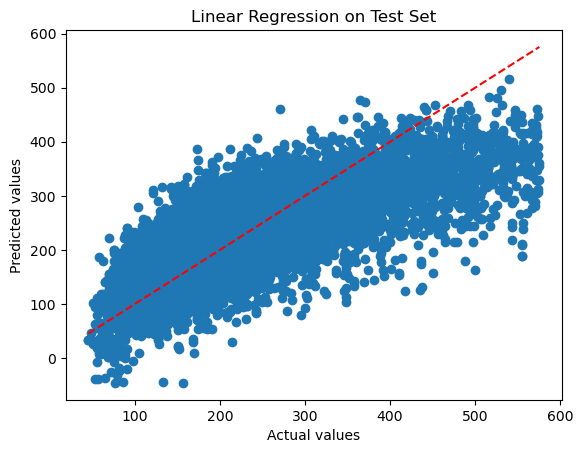

In [80]:
plt.scatter(y_test, y_predicted)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Linear Regression on Test Set')
plt.show()

In [78]:
# looking at model summary statistics 

summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realsum   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2662.
Date:                Tue, 16 May 2023   Prob (F-statistic):               0.00
Time:                        15:18:02   Log-Likelihood:            -2.1603e+05
No. Observations:               38058   AIC:                         4.321e+05
Df Residuals:                   38037   BIC:                         4.323e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    384.8305      2.588    148.677      0.000     379.757     389.904
person_capacity           67.5442      1.630     41.434      0.000      64.349      70.739
host_is_superhost          6.3445      0.852      7.450      0.000       4.675       8.014
multi                     10.4416      0.925     11.290      0.000       8.629      12.254
biz                       21.9226      0.932     23.522      0.000      20.096      23.749
bedrooms                 217.0772      7.529     28.831      0.000     202.320     231.835
dist                    -128.5208      6.355    -20.224      0.000    -140.977    -116.065
metro_dist               -38.0694      7.658     -4.971      0.000     -53.079     -23.059
attr_index               426.8241     10.363     41.186      0.000     406.512     447.137
weekends                   5.3589      0.725      7.387      0.000       3.937       6.781
city_athens             -312.2292      2.524   -123.718      0.000    -317.176    -307.283
city_barcelona          -150.5767      2.716    -55.442      0.000    -155.900    -145.253
city_berlin             -136.9679      2.767    -49.502      0.000    -142.391    -131.545
city_budapest           -284.3162      2.571   -110.589      0.000    -289.355    -279.277
city_lisbon             -202.1917      2.460    -82.188      0.000    -207.014    -197.370
city_london             -105.0493      2.420    -43.404      0.000    -109.793    -100.305
city_paris              -109.4024      2.482    -44.078      0.000    -114.267    -104.538
city_rome               -247.7870      2.394   -103.519      0.000    -252.479    -243.095
city_vienna             -198.4407      2.606    -76.134      0.000    -203.549    -193.332
room_type_private_room   -85.8158      0.966    -88.794      0.000     -87.710     -83.922
room_type_shared_room   -160.5958      4.222    -38.036      0.000    -168.871    -152.320
==============================================================================
Omnibus:                     4416.625   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7016.404
Skew:                           0.831   Prob(JB):                         0.00
Kurtosis:                       4.290   Cond. No.                         43.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
mse = mean_squared_error(y_test, y_predicted)
print("Mean squared error:", mse)

Mean squared error: 5057.853227739482


###### although we have a solid Durbin-Watson score, we can see both from the plot and from our mse that our regression model does not fit the data well. It looks like our model tended to over estimate lower cost airbnbs and under estimate high cost airbnbs

In [81]:
# looking at predicted and actual values

data = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})
data.head(30)

,Actual,Predicted
11008,141.394784,191.519057
18410,210.600375,251.912390
9053,127.307003,226.503359
44405,156.604259,205.404121
8327,347.243233,224.816507
2663,76.629250,100.559756
13192,73.083611,34.768072
22038,174.510219,241.624971
45802,185.353996,202.567737
27825,317.034737,395.994424


In [10]:
# exporting out reg_data for future use

reg_data.to_csv(os.path.join(path,'machine_data.csv'))

### 03 | seeing if we can do better with a pls regression and cross validation

In [91]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score

In [110]:
# defining independent and dependent variables
y = reg_data['realsum']

X = reg_data.drop(['lat','lng','realsum'], axis = 1)

In [93]:
# remove high vif factors

vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                     variables         VIF
0              person_capacity    3.407079
1            host_is_superhost    1.521017
2                        multi    1.932392
3                          biz    2.274659
4           cleanliness_rating  121.912312
5   guest_satisfaction_overall  128.378525
6                     bedrooms    6.779252
7                         dist    8.252656
8                   metro_dist    2.760116
9                   attr_index    9.769361
10                  rest_index   12.850073
11                    weekends    2.016759
12                 city_athens    4.207819
13              city_barcelona    2.744991
14                 city_berlin    2.502095
15               city_budapest    3.351546
16                 city_lisbon    4.473522
17                 city_london    7.191857
18                  city_paris    4.830177
19                   city_rome    7.986073
20                 city_vienna    3.045760
21      room_type_private_room    2.715540
22       ro

In [111]:
# we have some crazy VIF factors so we will be removing some variables

# although cleanliness_rating has a high vif, we want to keep it in the mix because we believe that it is a good predictor of realSum and using a PLS regression will help mitigate effects of multicolinearity 

X = X.drop(['guest_satisfaction_overall','rest_index'], axis = 1)


In [98]:
# remove high vif factors

vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                 variables        VIF
0          person_capacity   3.406345
1        host_is_superhost   1.516279
2                    multi   1.930712
3                      biz   2.236836
4       cleanliness_rating  30.202439
5                 bedrooms   6.738194
6                     dist   7.622367
7               metro_dist   2.720410
8               attr_index   4.770903
9                 weekends   2.014290
10             city_athens   3.991164
11          city_barcelona   2.596973
12             city_berlin   2.396429
13           city_budapest   3.128644
14             city_lisbon   4.171446
15             city_london   6.514216
16              city_paris   4.272390
17               city_rome   6.637081
18             city_vienna   2.898824
19  room_type_private_room   2.697139
20   room_type_shared_room   1.027818


In [112]:
# creating a range of components to try
n_components_range = range(1, X.shape[1] + 1)

# setting up Kfold and creating variables for our for loop
kf = KFold(n_splits=5, shuffle=True, random_state=42)  
best_r2 = -np.inf
best_n_components = None

# running for loop to find best r2 and corresponding number of components 
for n_components in n_components_range:
    pls = PLSRegression(n_components=n_components)
    y_pred_cv = cross_val_predict(pls, X, y, cv=kf)
    r2_cv = r2_score(y, y_pred_cv)
    if r2_cv > best_r2:
        best_r2 = r2_cv
        best_n_components = n_components


In [113]:
# training the model with best number of components and printing results
pls = PLSRegression(n_components=best_n_components)
pls.fit(X, y)
y_pred = pls.predict(X)
final_r2 = r2_score(y, y_pred)

print("Best number of components:", best_n_components)
print("Cross-validated R-squared with best number of components:", best_r2)
print("Final R-squared with best number of components:", final_r2)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error (MSE):", mse)


Best number of components: 21
Cross-validated R-squared with best number of components: 0.5853329865487448
Final R-squared with best number of components: 0.5858306564350912
Mean Squared Error (MSE): 4956.706955838516


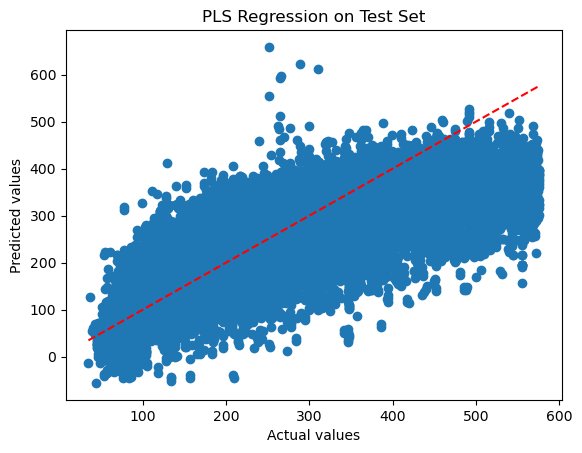

In [114]:
plt.scatter(y, y_pred)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('PLS Regression on Test Set')
plt.show()

In [108]:
coefficients = pls.coef_

# Print the coefficients
for i, regressor in enumerate(X.columns):
    print(f'Regressor: {regressor}, Coefficient: {coefficients[i]}')

Regressor: person_capacity, Coefficient: [20.70779998]
Regressor: host_is_superhost, Coefficient: [2.7977774]
Regressor: multi, Coefficient: [4.72880653]
Regressor: biz, Coefficient: [10.37840446]
Regressor: bedrooms, Coefficient: [12.81254639]
Regressor: dist, Coefficient: [-11.75162815]
Regressor: metro_dist, Coefficient: [-2.52386117]
Regressor: attr_index, Coefficient: [21.23153613]
Regressor: weekends, Coefficient: [3.07457919]
Regressor: city_athens, Coefficient: [-97.05857758]
Regressor: city_barcelona, Coefficient: [-34.26399138]
Regressor: city_berlin, Coefficient: [-30.07557935]
Regressor: city_budapest, Coefficient: [-78.11942942]
Regressor: city_lisbon, Coefficient: [-65.36943893]
Regressor: city_london, Coefficient: [-40.98530417]
Regressor: city_paris, Coefficient: [-35.6637832]
Regressor: city_rome, Coefficient: [-96.19304124]
Regressor: city_vienna, Coefficient: [-51.36556131]
Regressor: room_type_private_room, Coefficient: [-41.71988328]
Regressor: room_type_shared_roo

/Users/johntam/opt/anaconda3/envs/da_python/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
